In [1]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt

import fsc_utils as fsc

In [2]:
cmap_a = [plt.get_cmap('tab20c').colors[idx] for idx in [0, 4, 8, 12]]
cmap_b = [plt.get_cmap('tab20c').colors[idx] for idx in [2, 6, 10, 12]]

In [3]:
# You will need the 3-D volume from: https://www.ebi.ac.uk/emdb/EMD-4869

tomo_file = '' 

In [4]:
with mrcfile.open(tomo_file) as mrc:
    tomo_full = mrc.data
    tomo_voxel = mrc.voxel_size.x
    mrc.close()
    
# Pick region of tomogram to denoise
subtomo = tomo_full[:, 450:914, 325:789]
subtomo_slice = subtomo[226]  # denoise just this slice for simplicity

# Low-pass filter for comparison to Wiener filter
subtomo_lpf = fsc.low_pass_filter(subtomo_slice, tomo_voxel, 50)

# Select a noise slice for whitening transform
noise_slice = tomo_full[50, 450:914, 325:789]

In [5]:
shape = subtomo_slice.shape

r = shape[0] // 2
r_corner = int(np.ceil(np.sqrt(np.sum([s**2 for s in shape]))/2))

signal_slice_raps = fsc.compute_spherically_averaged_power_spectrum(subtomo_slice, r_corner) 
noise_slice_raps = fsc.compute_spherically_averaged_power_spectrum(noise_slice, r_corner)

freq = fsc.get_radial_spatial_frequencies(subtomo, tomo_voxel)

In [6]:
# whiten the subtomogram
y_whitened = fsc.whitening_transform(subtomo_slice, noise_slice, r_corner)

# upsample
y_upsample = fsc.fourier_upsample(y_whitened, 2)

In [7]:
EPSILON = 1e-8

### compute the SFSC ###
sfsc_upsample = np.mean(fsc.single_image_frc(y_upsample, r, whiten_upsample=True), axis=0)
sfsc_upsample = np.where(sfsc_upsample > EPSILON, sfsc_upsample, EPSILON)

# # or the following approximately equal alternatives
# ssnr_estimate = (signal_slice_raps[:r] - noise_slice_raps[:r]) / noise_slice_raps[:r]
# fsc_from_ssnr = ssnr_estimate / (1 + ssnr_estimate)
# fsc_from_ssnr = np.where(fsc_from_ssnr > EPSILON, fsc_from_ssnr, EPSILON)

# ps_w = fsc.compute_spherically_averaged_power_spectrum(y_whitened, r)
# fsc_from_ps = (ps_w - 1) / ps_w
# fsc_from_ps = np.where(fsc_from_ps > EPSILON, fsc_from_ps, EPSILON)

In [8]:
### apply a Wiener filter based on the SFSC ###

# Y = fsc.ft2(subtomo_slice)

Yw = fsc.ft2(y_whitened)
rdists = fsc.radial_distance_grid(Yw.shape)

for ri in range(r)[1:]:  # pick range of shells to filter
    mask = fsc.shell_mask(rdists, ri)
    Yw[mask] = sfsc_upsample[ri] * Yw[mask] * np.sqrt(noise_slice_raps[ri])
    # Y[mask] = sfsc_upsample[ri] * Yw[mask] # if using the original signal

# #optional step - additional low-pass filter based on e.g. 1/7 threshold
res = fsc.linear_interp_resolution(sfsc_upsample[1:], freq[1:], v=1/7)
m_idx = np.argmin(abs(freq - 1/res))
sphere_mask = fsc.sphere_mask(rdists, m_idx)
Yw = sphere_mask * Yw

y_filtered = fsc.ift2(Yw)

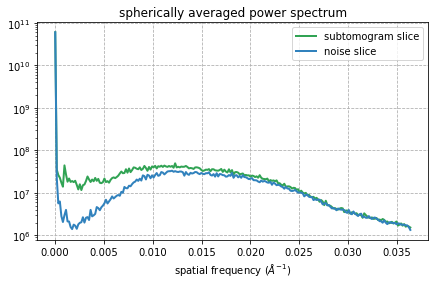

In [9]:
plt.figure(figsize=(7,4))

plt.semilogy(freq[:], signal_slice_raps[:r], color=cmap_a[2], linewidth=2, label='subtomogram slice')
plt.semilogy(freq[:], noise_slice_raps[:r], color=cmap_a[0], linewidth=2, label='noise slice') 

plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('spherically averaged power spectrum')

plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=10)

plt.grid(which='major', linestyle='--')

plt.legend()
# plt.savefig('')
plt.show()

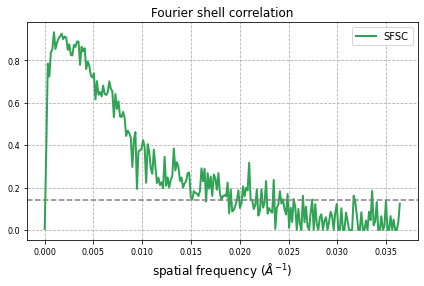

In [10]:
plt.figure(figsize=(7,4))

plt.plot(freq, sfsc_upsample, color=cmap_a[2], linewidth=2, label='SFSC')

plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('Fourier shell correlation')

plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=10)

plt.grid(which='major', linestyle='--')

plt.legend()
plt.axhline(1/7, linestyle='--', color='grey')
# plt.savefig('')
plt.show()

			full tomogram slice


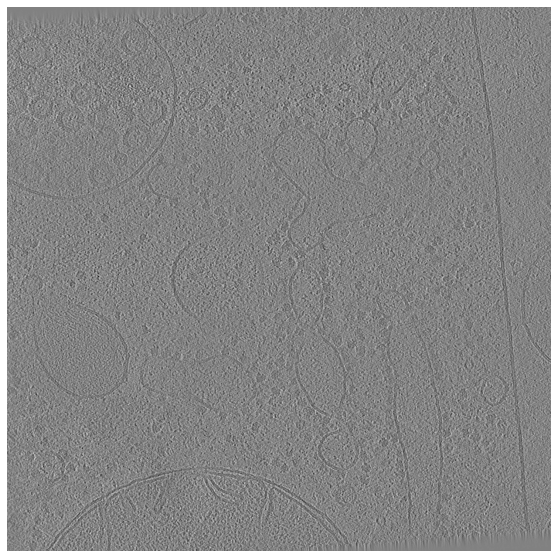

	sub tomogram noise slice


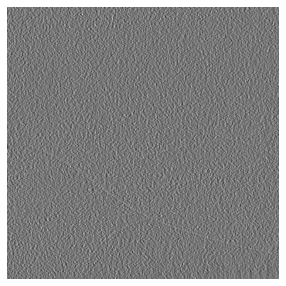

	sub tomogram slice


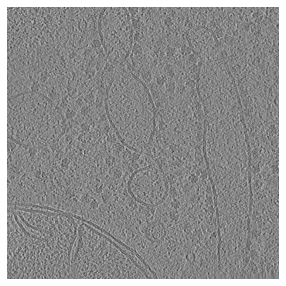

	sub tomogram slice lpf


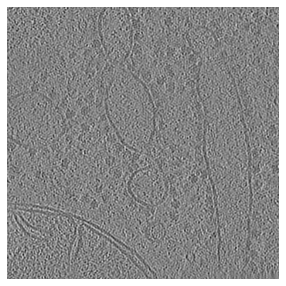

sub tomogram slice Wiener filter


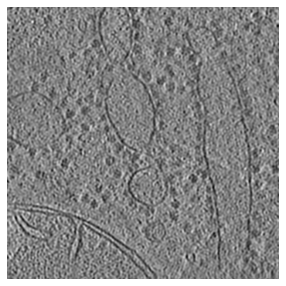

In [11]:
print("\t\t\tfull tomogram slice")
plt.figure(figsize=(10,10))
plt.imshow(tomo_full[226,...], cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

print("\tsub tomogram noise slice")
plt.figure(figsize=(5,5))
plt.imshow(noise_slice,cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

print("\tsub tomogram slice")
plt.figure(figsize=(5,5))
plt.imshow(subtomo[226,...],cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

print("\tsub tomogram slice lpf")
plt.figure(figsize=(5,5))
plt.imshow(subtomo_lpf,cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

print("sub tomogram slice Wiener filter")
plt.figure(figsize=(5,5))
plt.imshow(y_filtered, cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()